# Project: Evaluating Deep-Learning Models for Detecting Orientation and Flipping of X-Ray Scans
## Objective: Develop a Reliable Method to Detect Orientation and Flipping of Lateral Ceph Scans in the BB-Collection
---
### Background

In the BB-Collection, we identified several TIFF scans with inconsistent rotation and flipping. Specifically, Lateral Cephs should be oriented to the right and upwards.

### Strategy

Based on the findings in the work of Swami et al. [[1]](#References), we've determined that deep learning (DL) is the most appropriate method to accomplish this task.  
Specifically, we will make use of pre-trained models through *transfer learning*. This is the process of fine-tuning a model that has already been trained on millions of images to recognize more than 1000 classes of objects.  

We will evaluate various models with different architectures and sizes (number of neurons and layers), and assess their performance specifically within the context of the BB-Collection.  

### Preparing the trainig-set
We will use a subset of the BB-Collection scans, specifically the *Laterals* that are available on the AAOF website which are already correctly oriented (patient looking to the right).  
For each file we need to generate all possible combinations of rotation (in 90 degrees steps) and flip. We will use this augmented dataset to train the DL models.

In [1]:
# Usual imports

from fastai.vision.all import *
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.patches as patches
import pickle
import re

In [3]:
# Augment the dataset:
# For each file generate all possible combinations of rotation and flip

path = Path("BB_AAOF_WEB/Laterals")
train_folder = "Train"
scans = list(path.glob("*.jpg"))
print(f"{len(scans)} Lateral scans in the BB_AAOF web collection")

1066 Lateral scans in the BB_AAOF web collection


In [ ]:
rotations = [90, 180, 270]

for scan in scans:
    img = Image.open(scan)
    img.save(f"{train_folder}/{scan.stem}_0.png")
    img_flip = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    img_flip.save(f"{train_folder}/{scan.stem}_0F.png")
    for rot in rotations:
        # img_rot = img.rotate(rot)
        img_rot = img.transpose(Image.Transpose[f"ROTATE_{rot}"])
        img_rot.save(f"{train_folder}/{scan.stem}_{rot}.png")
        img_rot_flip = img_rot.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        img_rot_flip.save(f"{train_folder}/{scan.stem}_{rot}F.png")

In [6]:
files = get_image_files("Train/FlipRot/")
print(f"{len(files)} BB_AAOF web collection files augmented with all possible rotation/flip combinations for training")

8528 BB_AAOF web collection files augmented with all possible rotation/flip combinations for training


In [7]:
# Set up fastai dataloaders and model to start training
# This function generates labels based on filenames

def label_func(f):
    match = re.search(r'_(.*?)\.png', f)
    return match.group(1)

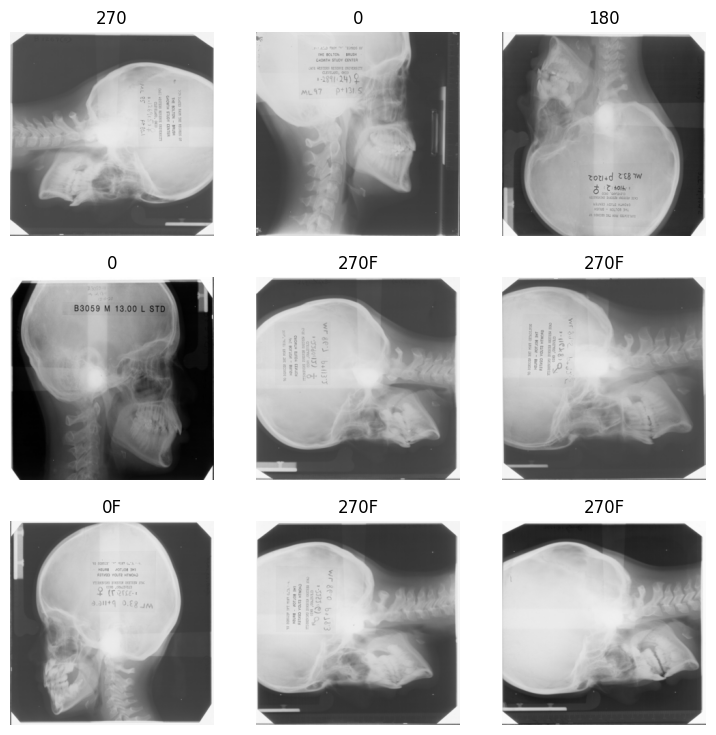

In [8]:
# Fastai dataloader - bundles images and labels for training the model

dls = ImageDataLoaders.from_name_func(train_folder, files, label_func, item_tfms=Resize(size=299, method=ResizeMethod.Squish), seed=42)
dls.show_batch()

/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frenchfaso/miniconda3/envs/fastai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


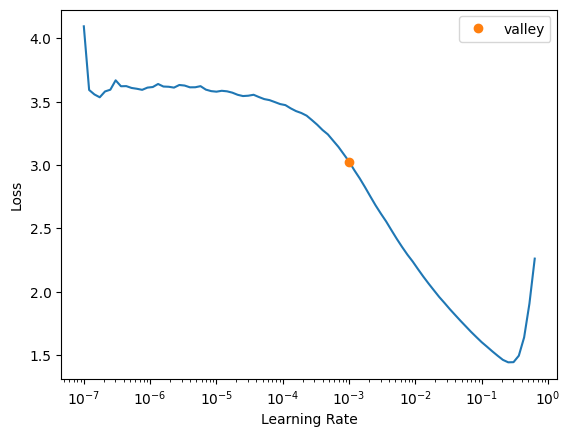

In [6]:
# Fastai pre-trained model 'Resnet18', quantized to fp16 to reduce computational and memory requirements
# We use fastai's learning rate finder to get a good range for this key hyperparameter to train the model

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.to_fp16()
lr = learn.lr_find()

In [7]:
# Next, we train (or fine-tune) the model for 15 epochs using the learning rate determined in the previous step

learn.fine_tune(15, lr.valley * 10)

epoch,train_loss,valid_loss,accuracy,time
0,0.230699,0.068449,0.981818,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.019979,0.011655,0.997654,00:21
1,0.012289,0.008467,0.997654,00:21
2,0.018429,0.031066,0.993548,00:20
3,0.006705,0.000059,1.000000,00:20
4,0.001417,0.000043,1.000000,00:21
5,0.019852,0.008223,0.998240,00:21
6,0.006833,0.004797,0.999413,00:21
7,0.001995,0.003727,0.999413,00:21
8,0.006989,0.003617,0.998827,00:21
9,0.001230,0.000118,1.000000,00:21


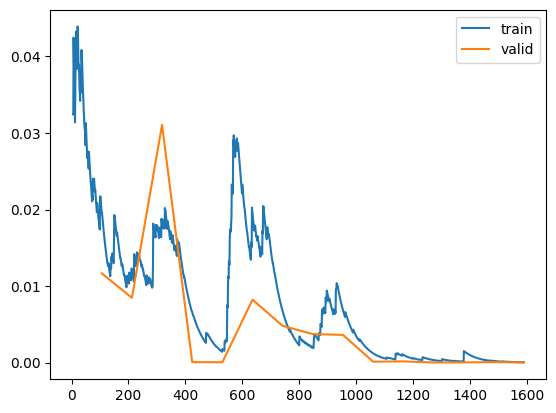

In [8]:
learn.recorder.plot_loss()

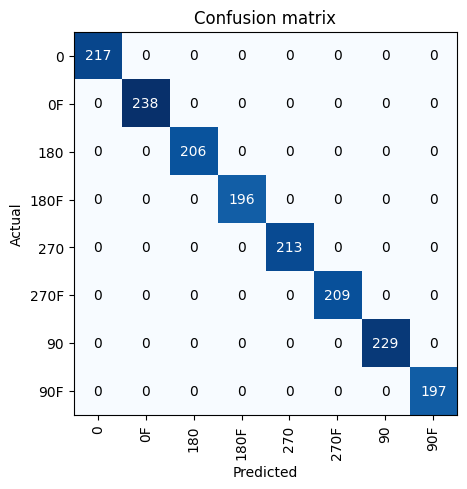

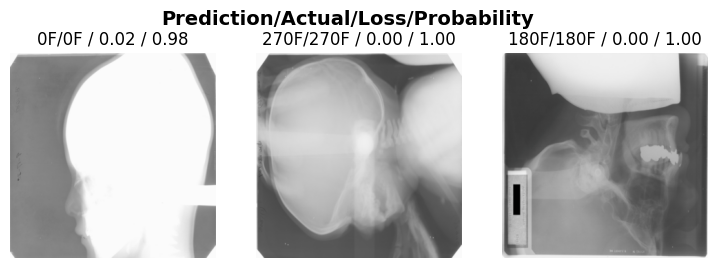

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(3)

Fine-tuning a relatively small model (Resnet18) for 15 epochs results in an accuracy of 100%.  
After inspecting various metrics (train/validation loss, confusion matrix, etc..) we save the trained model for future use.

In [10]:
learn.path = Path("./")
learn.export("models/fliprot_resnet18_fp16_01")

### Insights and Observations
The metrics look good, but an accuracy of 100% may suggest overfitting.  
We should test the model against unseen data (the test set) to confirm that the model has generalized well and has not overfit.

### Validation against unseen data
We compare the contents of our 'Train' folder (used for model training) with the 'Scans' folder (containing data from unseen patients) to identify how many new patients we have available to validate our model.

In [3]:
ls -l Scans/ | grep "^d" | wc -l

369


There are 369 patients in the Scans folder.  
Naming for laterals is not standardized, we need to take this into account.

In [9]:
# We need only laterals so we prepare a list with all different lateral folder names that occur in the Scans folder

folder = Path('Scans')
laterals = {d.name for d in folder.glob('*/*') if d.is_dir() and "lat" in d.name.lower()}
laterals

{'Lateral', 'Lateral Ceph', 'Lateral Skull', 'LateralCeph', 'Laterals'}

In [5]:
# Next we prepare a list with all lateral scans

files = folder.rglob("*.png")
scans = []
for f in files:
    if any([s in str(f) for s in laterals]):
        scans.append(f)

print(f"{len(scans)} lateral scans in Scans folder\nRandom sample:")
random.sample(scans, 3)

2712 lateral scans in Scans folder
Random sample:


[Path('Scans/B3120/Lateral/B3120L8.png'),
 Path('Scans/B3165/Laterals/B3165LM25y00m .png'),
 Path('Scans/B1170/Lateral/B1170LM10y06m.png')]

In [6]:
# Let's check the number of patients we have in the Scans folder

scans_patients = {p.parts[1] for p in scans}
print(f"{len(scans_patients)} Patients in Scans with Laterals\nRandom sample:")
print(random.sample(list(scans_patients), 5))

292 Patients in Scans with Laterals
Random sample:
['B5662', 'B3845', 'B0109', 'B3515', 'B0441']


In [7]:
# Let's check the number of patients in the BB_AAOF_WEB  folder

patients = set()
pattern = re.compile(r'CASEBolton(B\d{4}).*\.jpg$')
web_images = Path('BB_AAOF_WEB/Laterals')
for file_path in web_images.rglob('*.jpg'):
    filename = file_path.name
    match = pattern.search(filename)
    if match:
        # The first group contains the match we're interested in
        patients.add(match.group(1))

print(f"{len(patients)} Patients in BB_AAOF_WEB\nRandom sample:")
print(random.sample(list(patients), 5))

102 Patients in BB_AAOF_WEB
Random sample:
['B1051', 'B2817', 'B3484', 'B1269', 'B2429']


In [8]:
# Compare the 2 sets of Patients and compute the difference (patients not present in the training-set)

unseen_patients = scans_patients - patients
print(f"{len(unseen_patients)} 'unseen' patients with laterals")

279 'unseen' patients with laterals


In [9]:
# Finally we compile a list with all unseen lateral scans for validating the model

unseen_scans = [scan for scan in scans if not any(patient in str(scan) for patient in patients)]
print(f"{len(unseen_scans)} 'unseen' lateral scans")

2431 'unseen' lateral scans


Next we validate our trained model on a random sample of 100 items from the list of unseen laterals.  
We mark with a red rectangle all scans for which the model had a confidence less than 85%.

In [10]:
# Load the saved model if present

model = Path('models/fliprot_resnet18_fp16_01')
if model.exists():
    learn = load_learner(model)

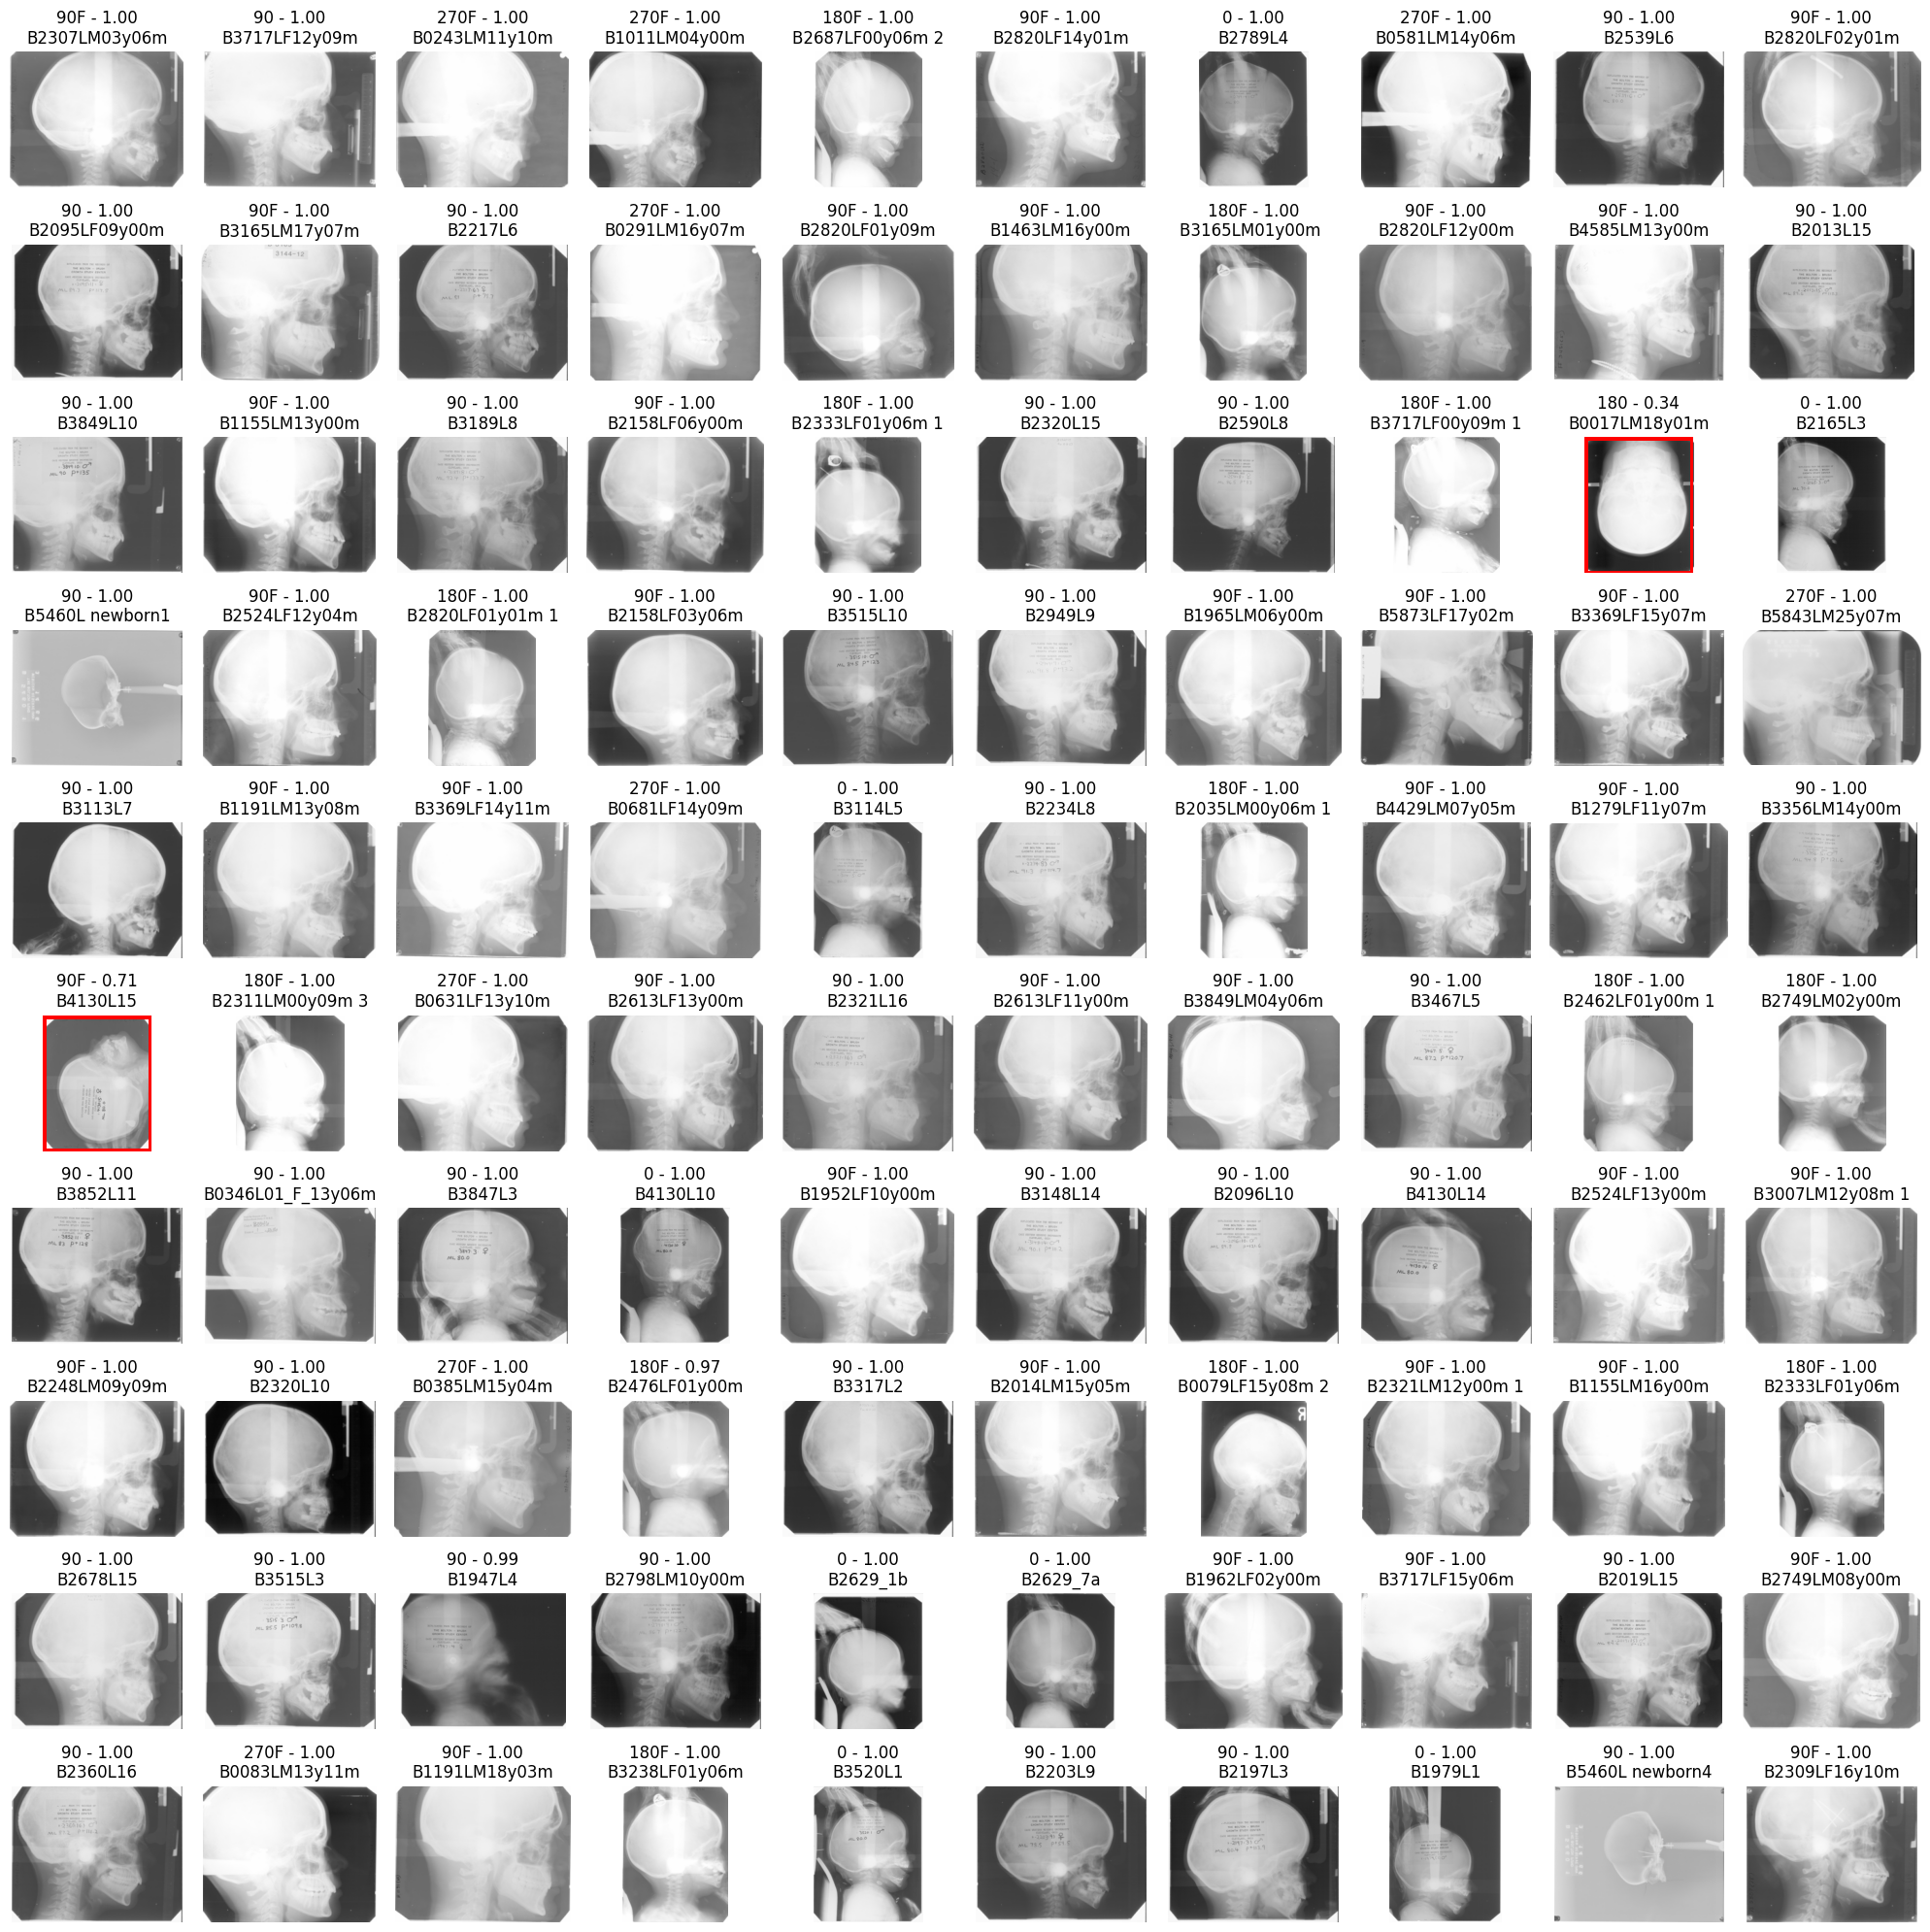

In [33]:
grid_x = 10
grid_y = 10

random.seed(3)
sample_images = random.sample(unseen_scans, grid_x * grid_y)

# Initialize a new plot
fig, axs = plt.subplots(grid_y, grid_x, figsize=(20, 20))

# Open and display each image
for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    img.thumbnail((256,256))
    pred_class, pred_idx, outputs = learn.predict(img_path)
    label = str(pred_class)
    confidence = float(outputs[pred_idx])
    
    if confidence >= 0.85:
        match label:
            case "0F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            case "90":
                img = img.transpose(Image.Transpose.ROTATE_270)
            case "270":
                img = img.transpose(Image.Transpose.ROTATE_90)
            case "180":
                img = img.transpose(Image.Transpose.ROTATE_180)
            case "90F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                img = img.transpose(Image.Transpose.ROTATE_270)
            case "180F":
                img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
            case "270F":
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                img = img.transpose(Image.Transpose.ROTATE_90)
    
    ax = axs[i // grid_x, i % grid_x]
    ax.imshow(img)
    ax.set_title(f"{label} - {confidence:.2f}\n{img_path.stem}")
    ax.axis('off')

    if confidence < 0.85:
        rect = patches.Rectangle((0,0),img.shape[1],img.shape[0],linewidth=5,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

plt.tight_layout()

In [4]:
preds_pkl = Path('predictions.pkl')

if preds_pkl.exists():
    with open(preds_pkl, 'rb') as f:
        preds = pickle.load(f)
else:
    preds = []
    for scan in unseen_scans:
        pred_class, pred_idx, outputs = learn.predict(scan)
        label = str(pred_class)
        confidence = float(outputs[pred_idx])
        preds.append({
            "name": scan,
            "label": label,
            "conf": confidence
        })

    with open("predictions.pkl", "wb") as f:
        pickle.dump(preds, f)

In [5]:
filtered_preds = [p for p in preds if p["conf"] < 0.9]
len(filtered_preds)

28

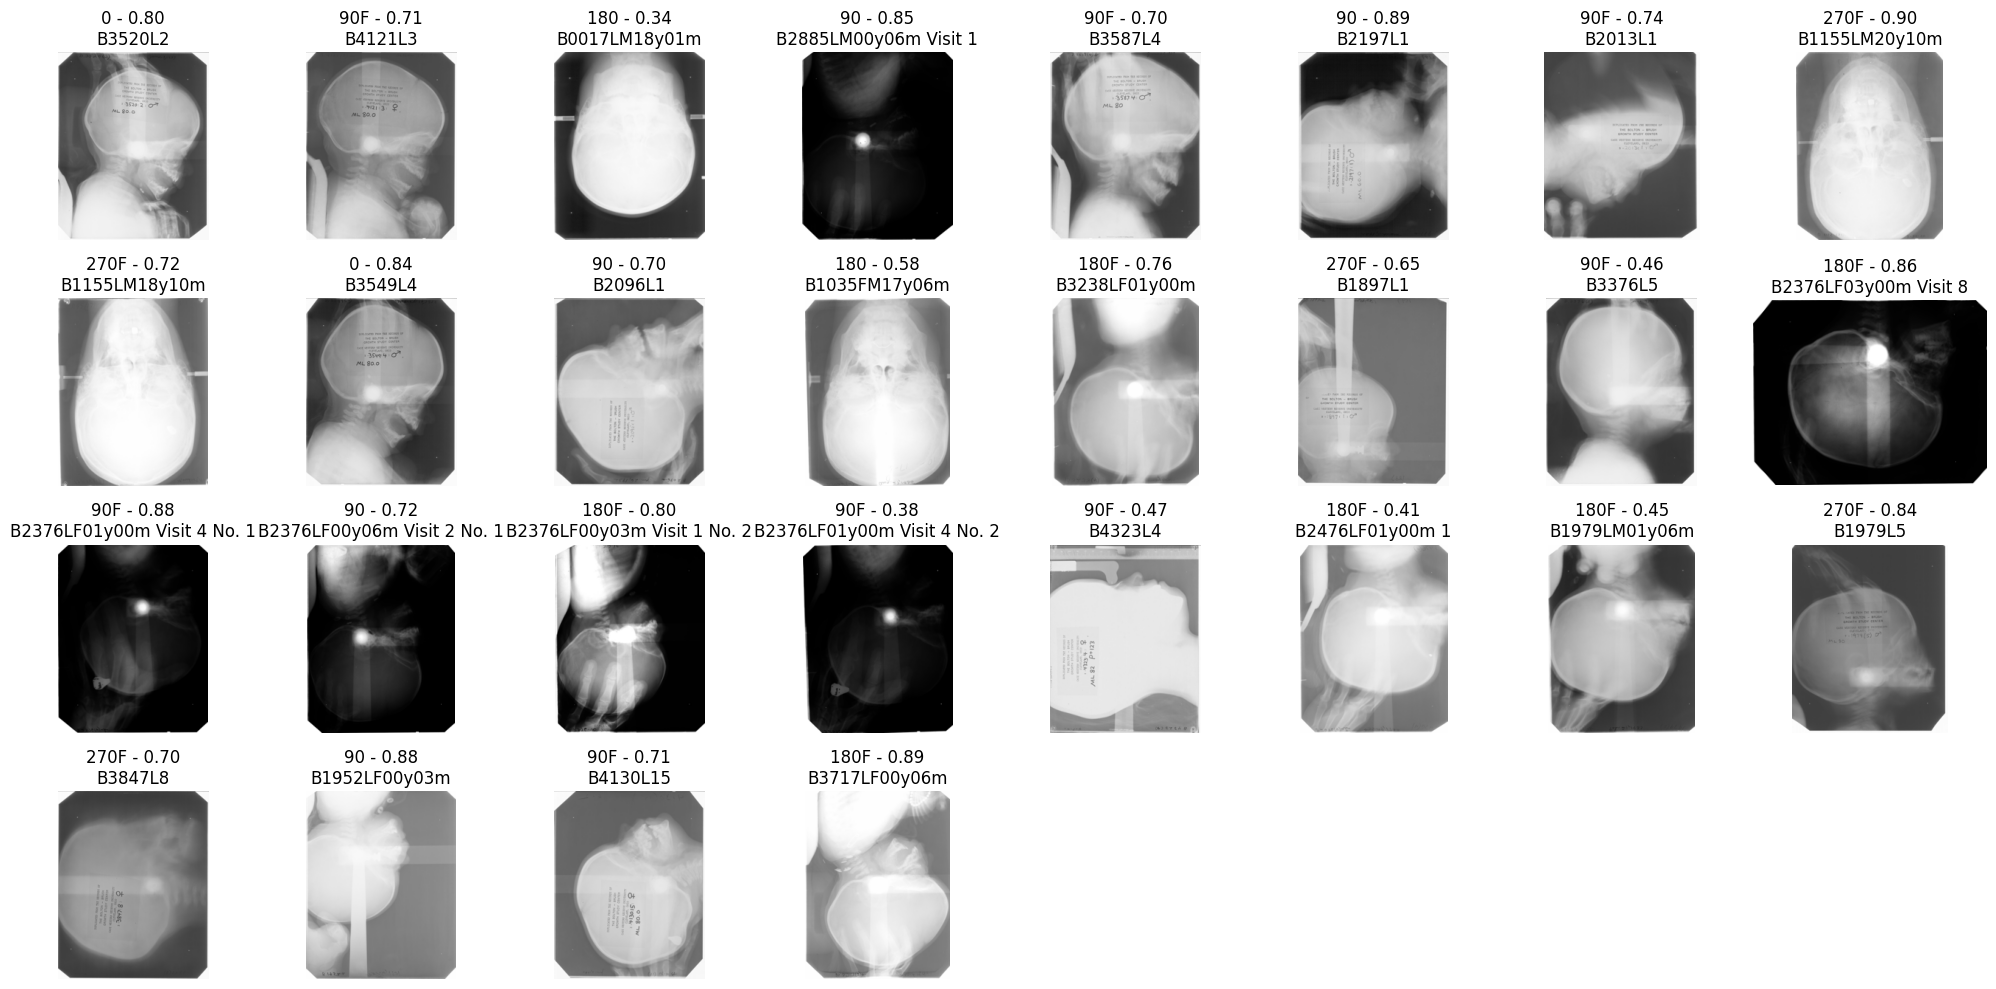

In [26]:
rows = 4
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
axs = axs.ravel()
for i, pred in enumerate(filtered_preds):
    img = Image.open(pred['name'])
    img.thumbnail((256,256))
    axs[i].imshow(img)
    axs[i].set_title(f"{pred['label']} - {pred['conf']:.2f}\n{pred['name'].stem}")
    axs[i].axis('off')

if len(filtered_preds) < len(axs):
    for j in range(len(filtered_preds), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

---
### References
[1]: K. Swami, P. P. Deshpande, G. Khandelwal and A. Vijayvargiya, "Why my photos look sideways or upside down? Detecting canonical orientation of images using convolutional neural networks," 2017 IEEE International Conference on Multimedia & Expo Workshops (ICMEW), Hong Kong, China, 2017, pp. 495-500, doi: 10.1109/ICMEW.2017.8026216.